<h3 align="center"> ## LSTM-DNN model </h3>

<h3 align="center">September 3, 2021</h3>

In [8]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
import keras
import numpy as np
import pydot
import psycopg2 as pg
import pandas.io.sql as psql

#connection = pg.connect("host='ds4a-demo-instance.cganmkarjo24.us-east-2.rds.amazonaws.com' dbname=energia user=postgres password='Laclave.'")

The data was stored on a AWS database which not longer exist, a copy of the normalized data is found on database.csv file.

# Load the data

Here we load the data from the database and normalize it, first we start by adding the energy demand and then we add the
energy price.

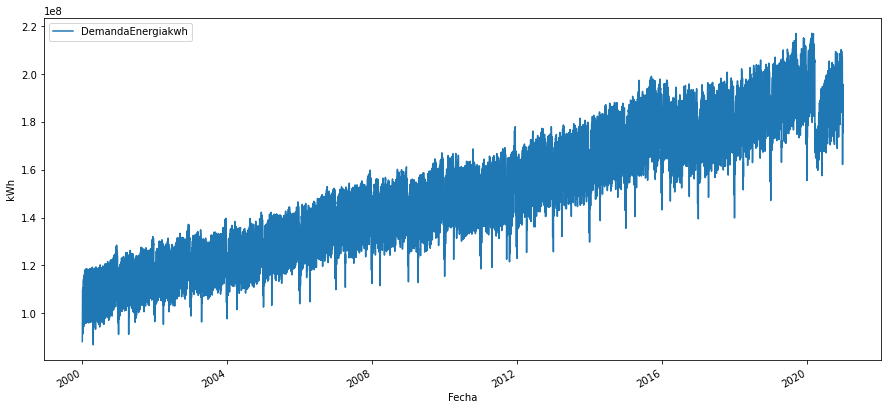

In [2]:


dg = pd.read_sql_query('select * from "Demanda_energia"',con=connection)

dg['Fecha']=dg['Fecha'].apply(str)
dg['Fecha']=pd.to_datetime(dg['Fecha'])

#dg['Precio Bolsa Nacional Ponderado']=dg['promedio']


total='DemandaEnergiakwh'
#

# plot data
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dg.plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)
#dg.plot(x='Fecha',y='DemandaNoAtendida',ylabel=r' kWh ',ax=ax1)
#df.plot(x='Fecha',y='Generacionkwh',ylabel=r' kWh ',ax=ax1)

dfinalday=dg.drop(columns=['Pk_idDemandaEnergia','Generacionkwh','DemandaNoAtendida']) #DemandaNoAtendida
#dfinalday

#fig.savefig('Demanda_Comercial_kWh_per_mercado_type.png')
#fig1.savefig('Demanda_Comercial_kWh_diaria.png')


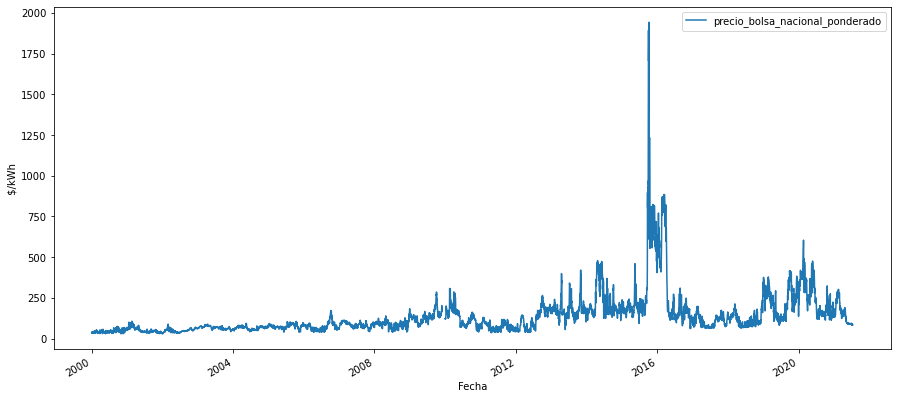

In [3]:
dg = pd.read_sql_query('select * from precio_bolsa_nacional',con=connection)


dg['fecha']=dg['fecha'].apply(str)
dg['fecha']=pd.to_datetime(dg['fecha'])
dg['Fecha']=pd.to_datetime(dg['fecha'])
dg['precio_bolsa_nacional_ponderado']=dg['promedio']
dg=dg.drop(columns='promedio')
dg=dg.drop(columns='fecha')

total='precio_bolsa_nacional_ponderado'
#

# plot data
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dg.plot(x='Fecha',y=total,ylabel=r' $/kWh ',ax=ax1)


dfinalday=dfinalday.join(dg.set_index('Fecha'), on='Fecha')
dfinalday=dfinalday.fillna(0)


# Normalize data
Now we normalize the data and save everything in the dataframe df and save an unnormalize copy of the energy price.

In [4]:
df=pd.DataFrame()
df['Fecha']=dfinalday['Fecha']

#meannA=dfinalday['DemandaEnergiakwh'].mean()
#stdnA=dfinalday['DemandaEnergiakwh'].std()
meannA=155247922.8975228
stdnA=27728694.604139626
rowval=dfinalday['DemandaEnergiakwh']
df['norm_DemandaEnergiakwh']=(rowval-meannA)/stdnA


#meannB=dfinalday['precio_bolsa_nacional_ponderado'].mean()
#stdnB=dfinalday['precio_bolsa_nacional_ponderado'].std()
meannB=134.33447502138475
stdnB=135.98355133235674
rowval=dfinalday['precio_bolsa_nacional_ponderado']
df['norm_precio_bolsa_ponderado']=(rowval-meannB)/stdnB



df['precio_bolsa_ponderado']=dfinalday['precio_bolsa_nacional_ponderado']

def normalize_precio(x):
    '''
    Normalize the energy price
    '''
    return (x-meannB)/stdnB

In [5]:
df

,Fecha,norm_DemandaEnergiakwh,norm_precio_bolsa_ponderado,precio_bolsa_ponderado
0,2000-01-01,-2.420094,-0.746166,32.868121
1,2000-01-02,-2.384662,-0.744941,33.034788
2,2000-01-03,-1.769346,-0.713779,37.272288
3,2000-01-04,-1.647871,-0.681299,41.688955
4,2000-01-05,-1.655314,-0.687152,40.893121
...,...,...,...,...
7665,2020-12-27,0.725982,-0.014842,132.316250
7666,2020-12-28,1.399165,0.263816,170.209167
7667,2020-12-29,1.459986,0.286687,173.319167
7668,2020-12-30,1.369820,0.268587,170.857917


# Spliting the data

Here we define some functions to split the data into the correct input form for our neural network which is a hybrid forecaster combining an LSTM and a DNN network. The motivation behind this hybrid structure is to include a recurrent layer that can learn and model the sequential relations in the time series data as well as a regular layer that can learn relations that depend on non-sequential data.


The inputs are divided between those that model sequential time data, e.g. past electricity prices, and those that model regular data, e.g. the energy demand of the previous day.

The inputs n_steps, columns and step_diff of the function split_dfsequence indicates the number of days included in the sequential time data, the regular data (in this case the energy demand) and how many days before the predicted date is the time series.

In [121]:

# univariate data preparation
from numpy import array

km=2

# split a univariate sequence into samples of nsteps
def split_dfsequence(sequence, n_steps,columns,step_diff):
    '''
        This function split the data into sequences of length n_steps of the 'norm_precio_bolsa_ponderado' starting
        'step_diff' days before saved in X1, X2 is the array with the columns 'columns' in the 'sequence'for the 
        previous day and y is the current price 'precio_bolsa_ponderado'
        
        Inputs:
        sequence= dataframe to be splitted
        n_steps= number of days to add from the  'norm_precio_bolsa_ponderado'
        columns=columns to be added for previous day values
        step_diff= days before the current date
    '''
    X1,X2, y = list(), list(), list()
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps+step_diff
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[columns][end_ix-2:end_ix-1], sequence['precio_bolsa_ponderado'][end_ix]
        X1.append(seq_x)
        X2.append(sequence['norm_precio_bolsa_ponderado'][i:end_ix-step_diff])
        y.append(seq_y)
    return array(X1),array(X2), array(y)
import keras.backend as K# Define SMAPE loss function

def smapeLoss(true,predicted):
    '''
    loss fuction to be implemented in the neural network
    '''
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

def mape(yo,y1):
    '''
    mape error fuction 
    sMAPE=(100/N)* SUM(  |Xk-Yk|/(|Xk|+|Yk|)/2  )
    '''
    mape=2*abs(y1-yo)/(abs(y1)+abs(yo))
    return 100*sum(mape)/len(yo)

def train_test_split(X11,Y1,p):
    ndata = len(Y1)
    idx_train =int(p*ndata)
    idx_test  = np.asarray(list(set(range(ndata)) - set(range(idx_train))))
    idx_train =np.asarray(list(set(range(idx_train)))) 
    X1_train=X11[idx_train]
    X1_test=X11[idx_test]
    Y_train=Y1[idx_train]
    Y_test=Y1[idx_test]
    return X1_train,Y_train,X1_test,Y_test
#keras.utils.plot_model(model

Here we split into the sequential time data and regular data, then we futher split it into training and test sets, we choose energy prices from two weeks before to predict the future price.

In [122]:
seq=df['norm_precio_bolsa_ponderado']
n_steps =14
step_diff=1

#columns=['weekend','norm_precio_ofertado_medio_por_cantidad_hidraulica_ $/kWh','norm_precio_ofertado_medio_por_cantidad_termica_ $/kWh' ,'norm_enzo']
#columns=['norm_DemandaEnergiakwh','norm_enzo','norm_prom_precio_ofertado_hidraulica_ $/kWh','norm_prom_precio_ofertado_termica_ $/kWh' ]
#columns=['norm_DemandaEnergiakwh','norm_enzo' ]
columns=['norm_DemandaEnergiakwh']
#columns=['norm_precio_ofertado_medio_por_cantidad_hidraulica_ $/kWh' ]
n_features=len(columns)
# split into samples
X1,X2, Y = split_dfsequence(df, n_steps,columns,step_diff)
# summarize the data

X1 = X1.reshape((X1.shape[0], n_features))
X2 = X2.reshape((X1.shape[0],1, n_steps))
#X1 = X1.reshape((X1.shape[0], km-1))
X1.shape
X2.shape


(7655, 1, 14)

In [123]:
X1.shape

(7655, 1)

In [124]:
X1_train,X2_train,Y_train,X1_test,X2_test,Y_test= train_test_split(X1,X2,Y,0.8)

# LSTM-DNN model

This a hybrid forecaster combining an LSTM and a DNN network. The motivation behind this hybrid structure is to include a recurrent layer that can learn and model the sequential relations in the time series data as well as a regular layer that can learn relations that depend on non-sequential data.

This model was already used in (https://www.sciencedirect.com/science/article/pii/S030626191830196X), there the authors compared over 27 other common approaches for day-ahead electricity price forecasting and was shown to obtain a predictive accuracy that is statistically significantly better than all other non ML models. 

We choose this model over the other ML models on the paper since this has way better mid and long term forecasting than the others and shows a decent long term predictions if more variables besides the energy demand are added (for example enzo,
hydroelectric generation, termical energy generation, Offer price etc.)

The model uses a DNN to process the regular inputs and an LSTM to process the time sequences . Then, the outputs of these two networks are concatenated into one vector and this vector is fed into a regular output layer.

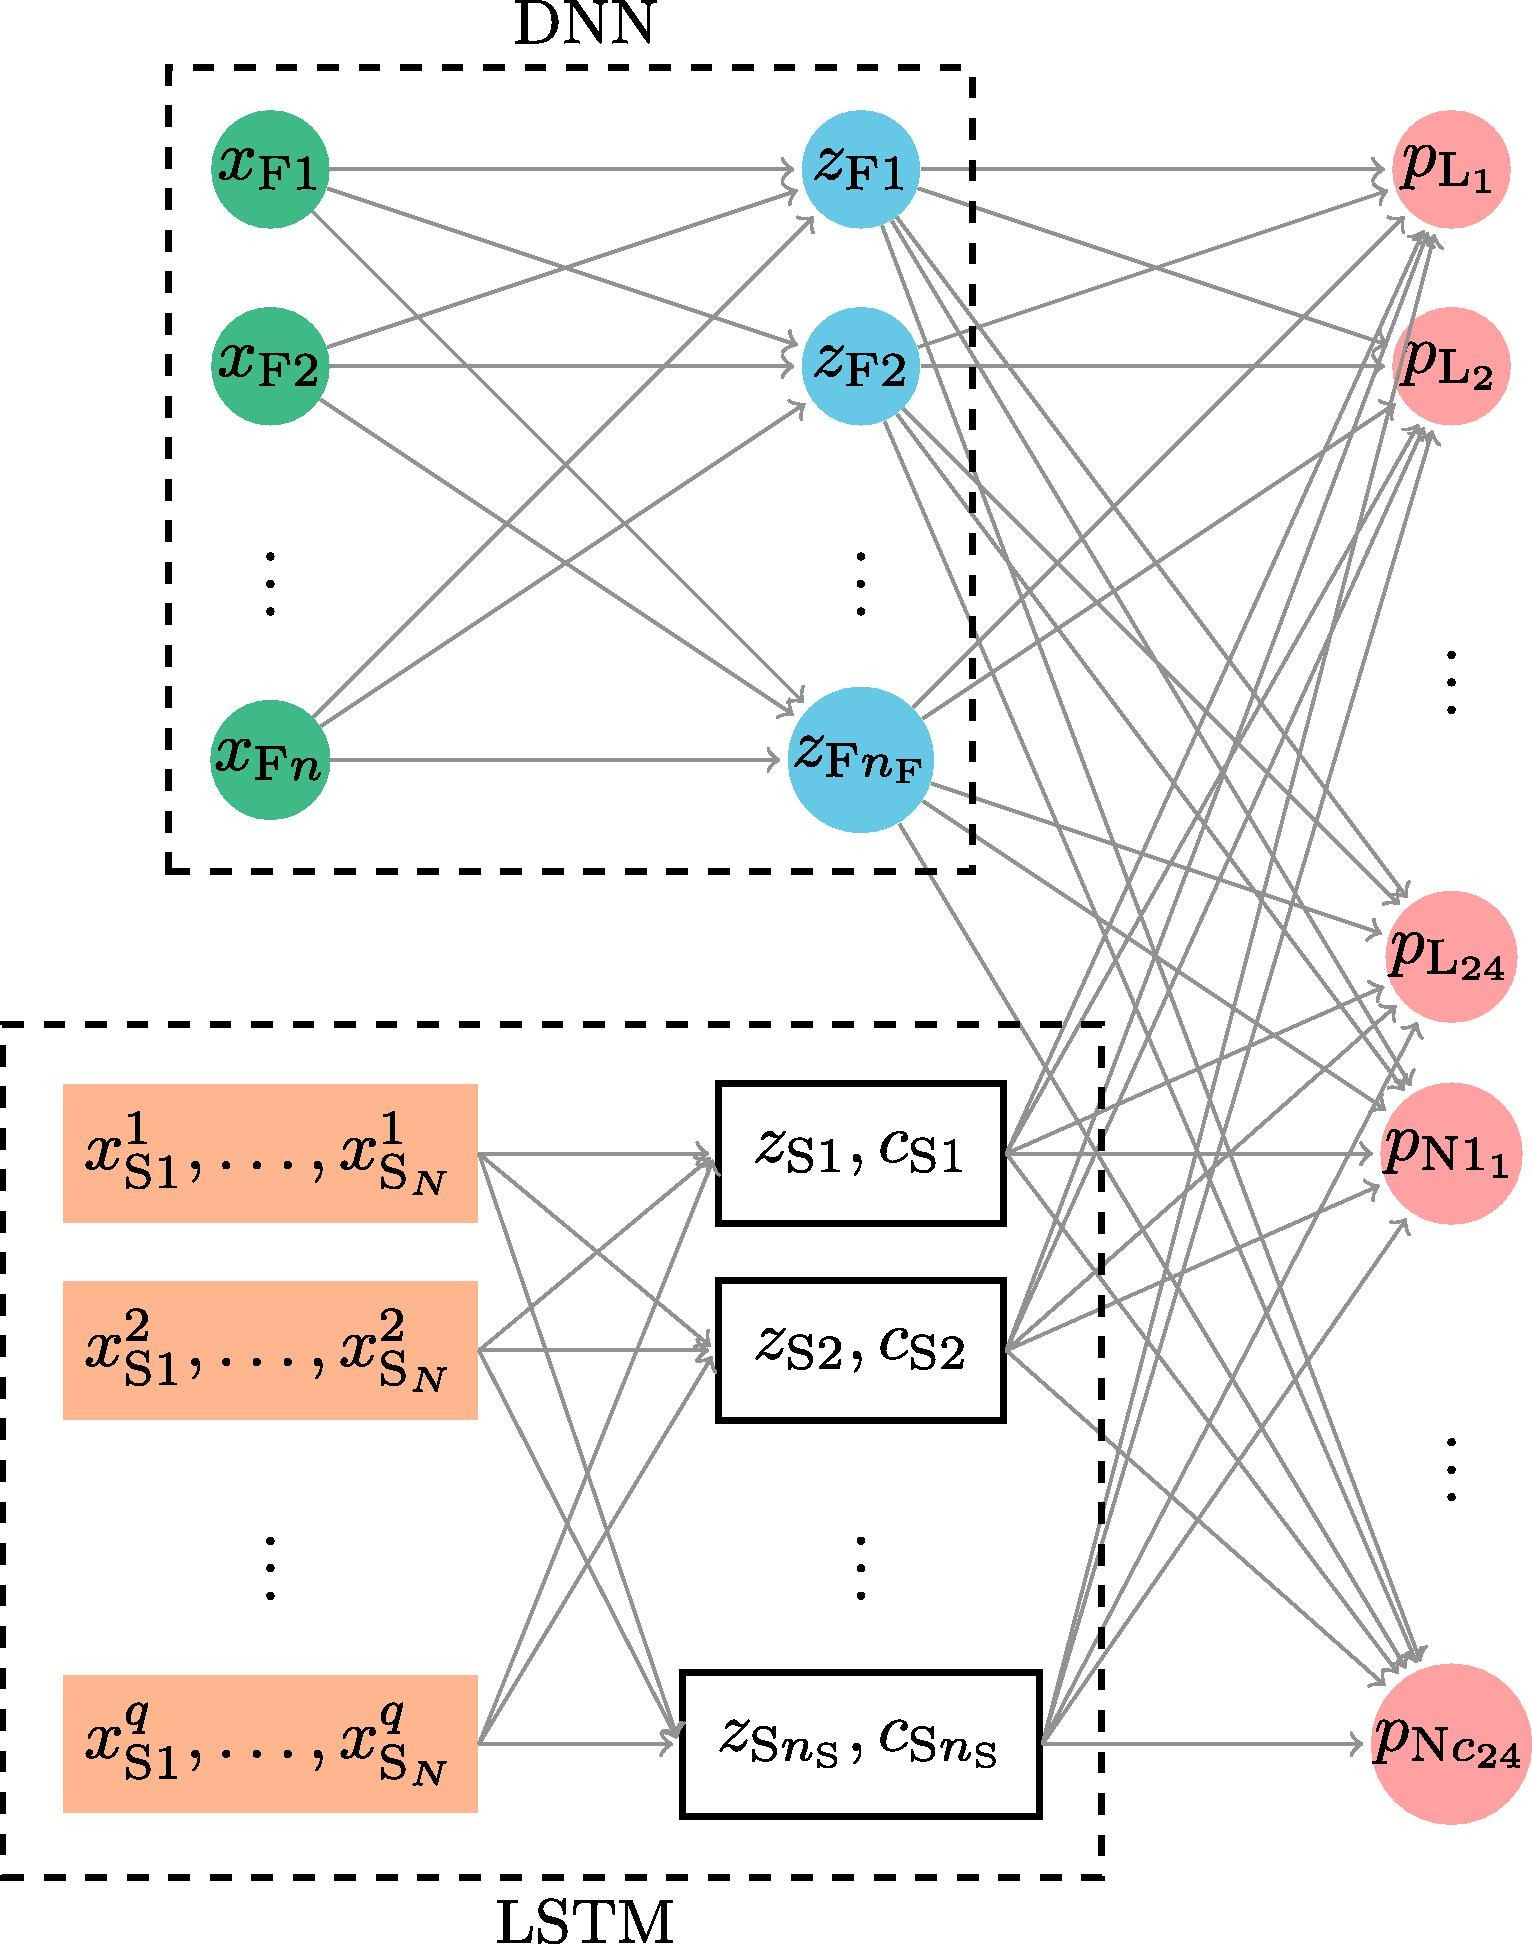

In [125]:
#
def create_model(n,m):
    
    inputA = Input(shape=(km-1))
    #inputA = Input(shape=(n_features))
    inputB = Input(shape=(1,n_steps))

    # the first branch operates on the first input
    #x = Dense(n, activation="relu",kernel_regularizer=keras.regularizers.l2(1e-4))(inputA)
    x = Dense(n, activation="relu")(inputA)

    #x = Dense(4, activation="relu")(x)
    #x=keras.layers.Dropout(0.5)(x)
    x = Model(inputs=inputA, outputs=x)

    # the second branch opreates on the second input
    #y = LSTM(m, activation="tanh",recurrent_activation=None,kernel_regularizer=keras.regularizers.l2(1e-4))(inputB)
    #y = LSTM(m, activation="tanh",kernel_regularizer=keras.regularizers.l2(1e-4))(inputB)
    y = LSTM(m, activation="tanh",recurrent_activation=None)(inputB)
    #y = LSTM(m, activation="tanh")(inputB)
    y=keras.layers.Dropout(0.5)(y)
    #y = Dense(32, activation="relu")(y)


    y = Model(inputs=inputB, outputs=y)


    # combine the output of the two branches
    combined = keras.layers.concatenate([x.output, y.output])
    # apply a FC layer and then a regression prediction on the
    # combined outputs
   #z = Dense(2, activation="relu")(combined)
    z=combined
    #z=keras.layers.GlobalMaxPooling1D(z)
    z=keras.layers.Dropout(0.2)(z)
    z = Dense(1)(z)
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[x.input, y.input], outputs=z)
    return model




def train_model(model,min_delta,patience,epochs):
    path_checkpoint = "model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=min_delta, patience=patience)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )    
    
    history = model.fit(
        [X1_train,X2_train], Y_train,
        epochs=epochs,
        # 9 for 4 col //10 for 2 col //28 for 1 col
        validation_data=([X1_test,X2_test],Y_test),
        callbacks=[es_callback, modelckpt_callback]#,batch_size=32,
    )    
    return history

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    

# Model training

 We train the model with 184 neurons for the LSMT part and 40 for the DNN part, train during 22 epochs with early stopping.

Epoch 1/22
192/192 [==============================] - 3s 6ms/step - loss: 1.9455 - val_loss: 1.9626

Epoch 00001: val_loss improved from inf to 1.96256, saving model to model_checkpoint.h5
Epoch 2/22
192/192 [==============================] - 0s 2ms/step - loss: 1.4439 - val_loss: 1.7452

Epoch 00002: val_loss improved from 1.96256 to 1.74519, saving model to model_checkpoint.h5
Epoch 3/22
192/192 [==============================] - 0s 2ms/step - loss: 0.9377 - val_loss: 1.4543

Epoch 00003: val_loss improved from 1.74519 to 1.45435, saving model to model_checkpoint.h5
Epoch 4/22
192/192 [==============================] - 0s 2ms/step - loss: 0.7548 - val_loss: 0.7833

Epoch 00004: val_loss improved from 1.45435 to 0.78334, saving model to model_checkpoint.h5
Epoch 5/22
192/192 [==============================] - 0s 2ms/step - loss: 0.4917 - val_loss: 0.3761

Epoch 00005: val_loss improved from 0.78334 to 0.37611, saving model to model_checkpoint.h5
Epoch 6/22
192/192 [===================

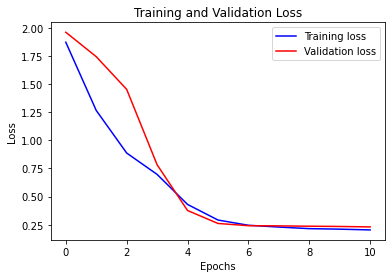

In [211]:
n=184#/2
m=40#83
#m=83


#create the model
my_model=create_model(n,m)


# compile the model
my_model.compile(optimizer='adam', loss=smapeLoss)


# train the model
epochs=22
min_delta=0.01455 #0.0145
patience=4
history=train_model(my_model,min_delta,patience,epochs)
visualize_loss(history, "Training and Validation Loss")


Here we check the sMape error for the training and test sets

In [212]:
x_input = [X1_test,X2_test]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat =my_model.predict(x_input, verbose=0)
yhat=yhat.reshape((yhat.shape[0], ))
print(mape(yhat.reshape((yhat.shape[0], )),Y_test))

23.0077673298431


In [213]:
x_input = [X1_train,X2_train]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = my_model.predict(x_input, verbose=1)
yhat=yhat.reshape((yhat.shape[0], ))
mape(yhat,Y_train)

192/192 [==============================] - 0s 817us/step


16.489228387137167

# Day ahead prediction



Here we show the day ahead prediction, these values can be greatly improved by training more the model and having more neurons in the DNN part. However doing those changes greatly damage the long term predictions.

192/192 [==============================] - 0s 738us/step


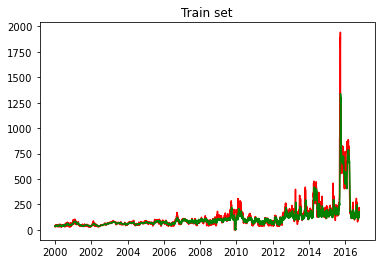

In [214]:
x_input = [X1_train,X2_train]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = my_model.predict(x_input, verbose=1)
yhat=yhat.reshape((yhat.shape[0], ))
Y_train
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
daux['train data']=Y_train
daux['LSTM-DNN model']=yhat
daux['Fecha']=df['Fecha']
daux.set_index('Fecha', inplace=True)
daux
plt.plot(daux['train data'], 'r',daux['LSTM-DNN model'],'g')
plt.title('Train set')
plt.show()

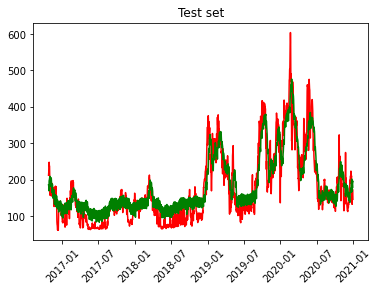

In [215]:
x_input =[X1_test,X2_test]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = my_model.predict(x_input, verbose=0)
yhat=yhat.reshape((yhat.shape[0], ))

daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
daux['test data']=Y_test
daux['LSTM-DNN model']=yhat
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[-len(Y_test):], inplace=True)
daux

plt.plot(daux['test data'], 'r',daux['LSTM-DNN model'],'g')
plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

# Long term predictions

For the long term we use the output prices of our model as input and take the current value of the energy demand  for the next predictions, we continue predicting over many days ahead. Next is shown 2 years ahead prediction.



In [222]:

dnn_numinputs =n_steps
dnn_numinputs
dnn_predictions=my_model.predict([X1_train,X2_train], verbose=0) 
dnn_predictions=normalize_precio(dnn_predictions)
no=len(X1_train)
naux=800
aux=[X1_test[:naux],X2_test[:naux]]
aux=my_model.predict(aux, verbose=0) 
aux=normalize_precio(aux)
dnn_predictions=np.concatenate((dnn_predictions, aux))
len(Y_test)
dnn_numinputs
No=len(Y_test)-naux

old_pred=dnn_predictions


daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']

daux['precio_norm']=pd.Series(normalize_precio(Y[6000:]))
daux['train_precio_norm']= pd.Series(normalize_precio(Y_train[6000:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model']=pd.Series(dnn_predictions[6000:].reshape(len(dnn_predictions[6000:]),))

#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[6000+n_steps+1:], inplace=True)
#daux

#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')
#plt.title('Test set')
#plt.xticks(rotation=45)
#plt.show()

In [223]:
%%time
for k in range(No):
    aux1=X1_test[naux+k].reshape(1,n_features)
    #aux1=X1_test[naux+k].reshape(1,km-1)
    aux2 = np.reshape(dnn_predictions[-dnn_numinputs:],(1,1,dnn_numinputs))
    new_pred = my_model.predict([aux1,aux2], verbose=0).flatten()
    new_pred=normalize_precio(new_pred)
    dnn_predictions = np.concatenate((dnn_predictions, new_pred.reshape(1,1)))
print('ended')

ended
Wall time: 42.1 s


days predicted 731


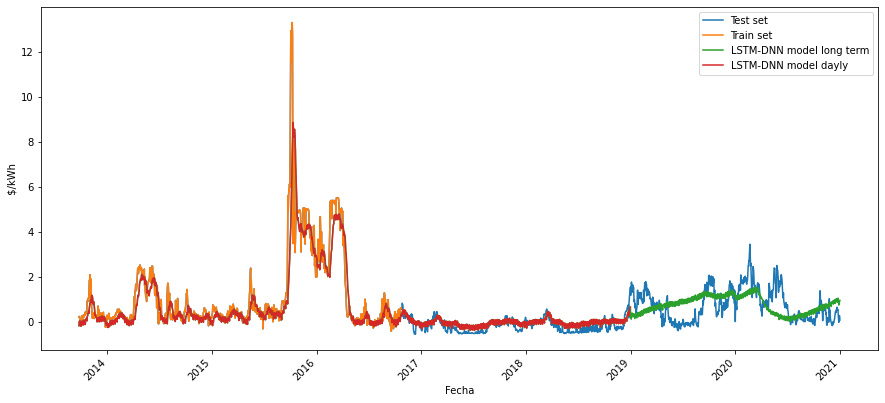

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

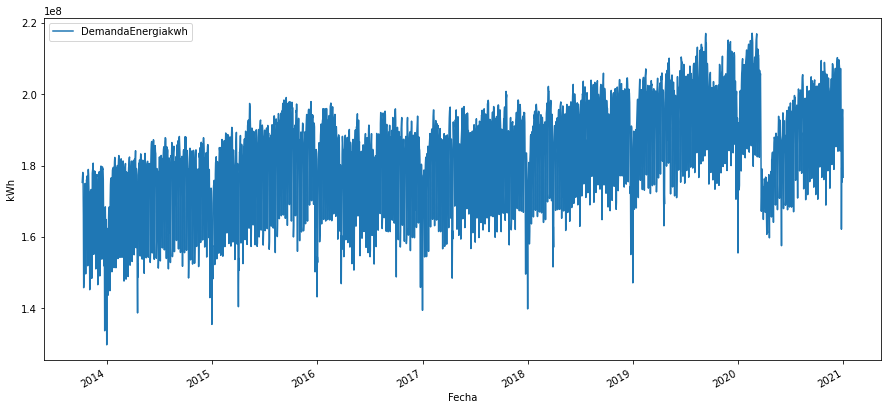

In [225]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']14
init_date=5000
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
print('days predicted',No)
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' $/kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)

days predicted 1431


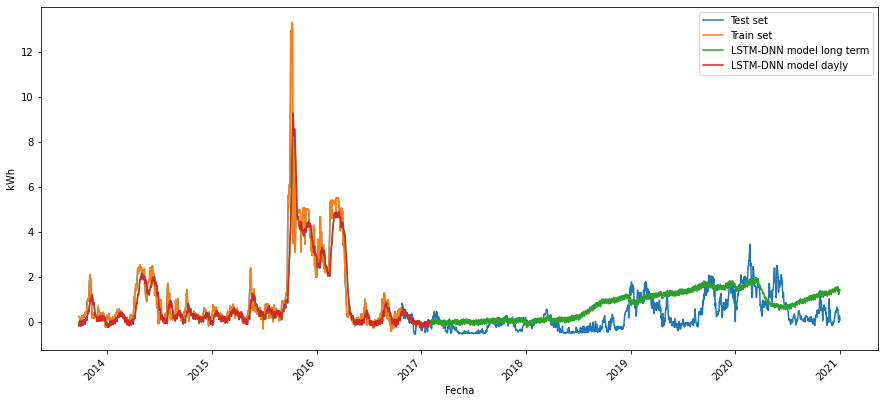

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

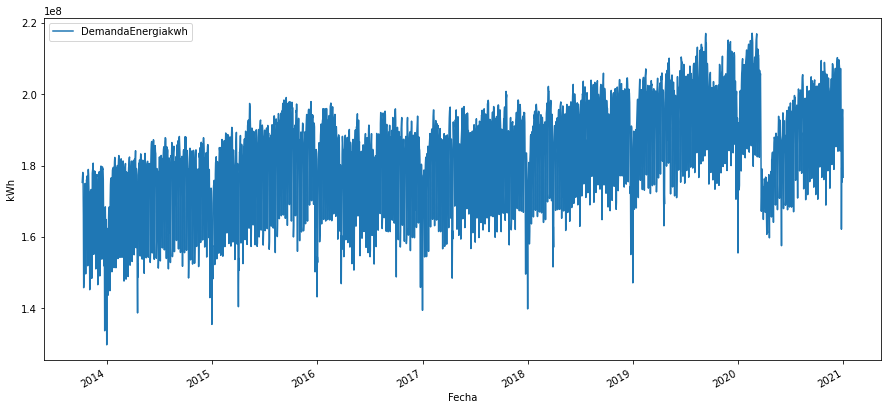

In [183]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
init_date=5000
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
print('days predicted',No)
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)

days predicted 1431


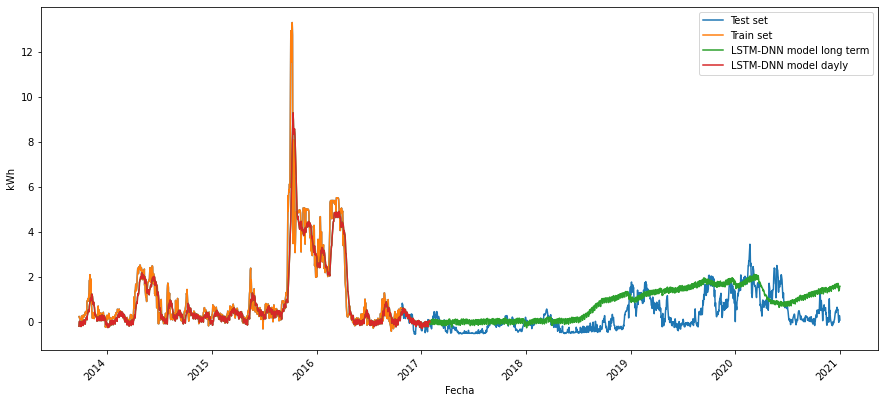

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

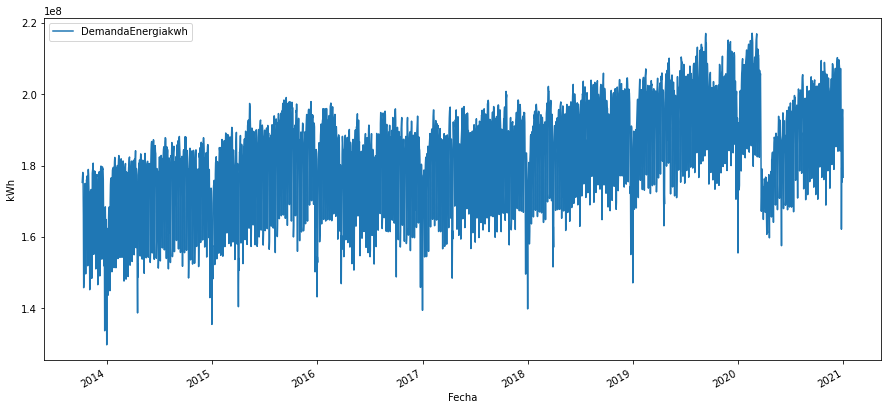

In [175]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']16
init_date=5000
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
print('days predicted',No)
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)

days predicted 1431


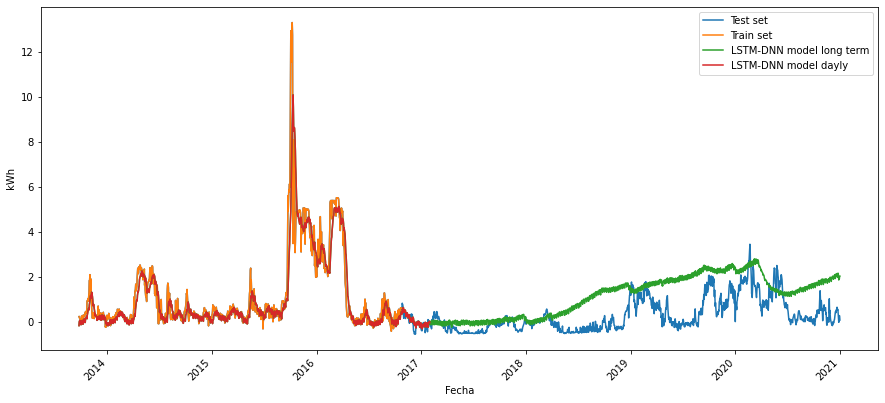

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

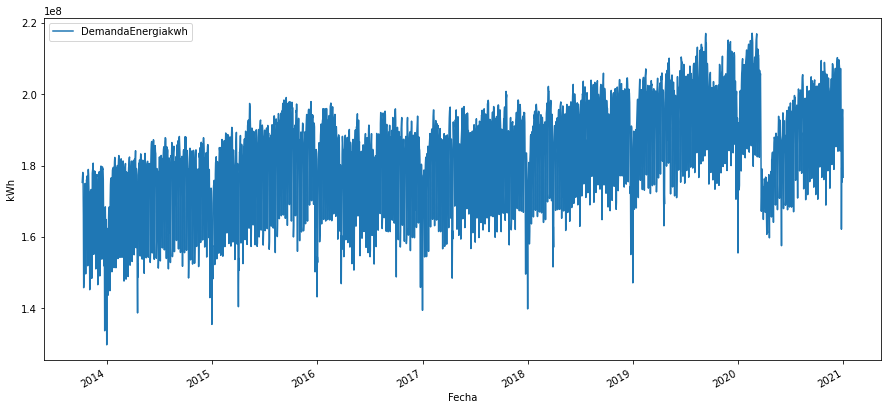

In [156]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']18
init_date=5000
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
print('days predicted',No)
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)


Even through we used the real energy demand values in this test, it is still posible to forecast long times ahead by predicting the energy demand values which is a far easier task due to the regularity and simple behavior of this variable.

This model can be futher improved by adding more variables to the DNN network giving better results like adding the enzo values or hidroelectric/ termic generation ratio, however it  requires to make auxiliary models to predict the new values on futher times for the new variables which can either easy as the energy demand or hard as predicting the energy price or even more like predicting enzo which is already hot topic in the literature where a satisfactory solution has not yet been found.

60 epoch training

In [18]:
x_input = [X1_test,X2_test]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat =my_model.predict(x_input, verbose=0)
yhat=yhat.reshape((yhat.shape[0], ))
print(mape(yhat.reshape((yhat.shape[0], )),Y_test))

21.14801643189589


192/192 [==============================] - 0s 948us/step


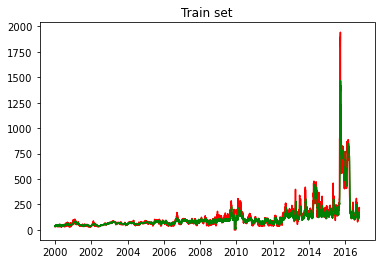

In [19]:
x_input = [X1_train,X2_train]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = my_model.predict(x_input, verbose=1)
yhat=yhat.reshape((yhat.shape[0], ))
Y_train
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
daux['train data']=Y_train
daux['LSTM-DNN model']=yhat
daux['Fecha']=df['Fecha']
daux.set_index('Fecha', inplace=True)
daux
plt.plot(daux['train data'], 'r',daux['LSTM-DNN model'],'g')
plt.title('Train set')
plt.show()

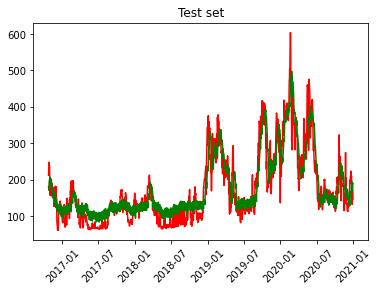

In [20]:
x_input =[X1_test,X2_test]
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = my_model.predict(x_input, verbose=0)
yhat=yhat.reshape((yhat.shape[0], ))

daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
daux['test data']=Y_test
daux['LSTM-DNN model']=yhat
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[-len(Y_test):], inplace=True)
daux

plt.plot(daux['test data'], 'r',daux['LSTM-DNN model'],'g')
plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

days predicted 1431


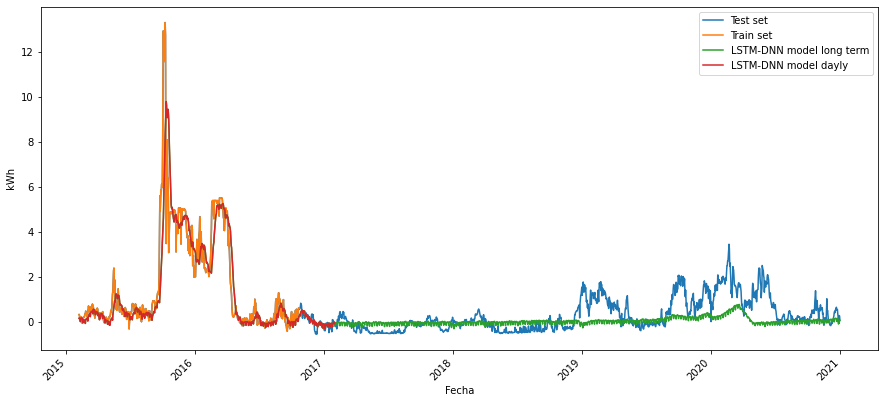

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

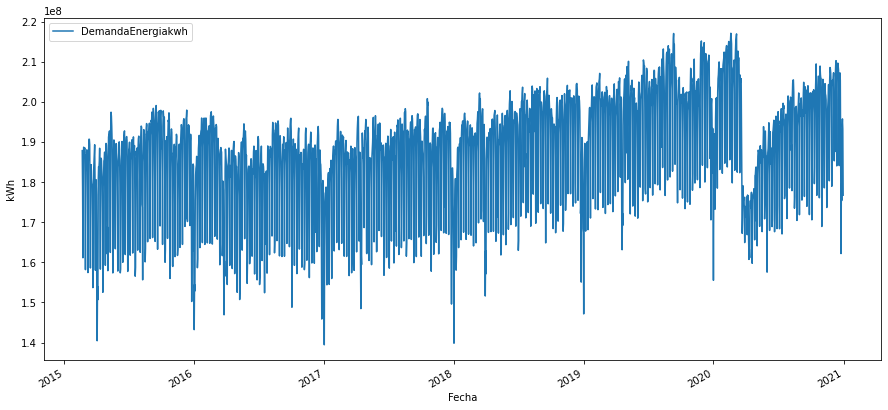

In [21]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
init_date=5500
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
print('days predicted',No)
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)

In [22]:
epochs=32
min_delta=0.000001#0.01455 #0.0145
patience=20

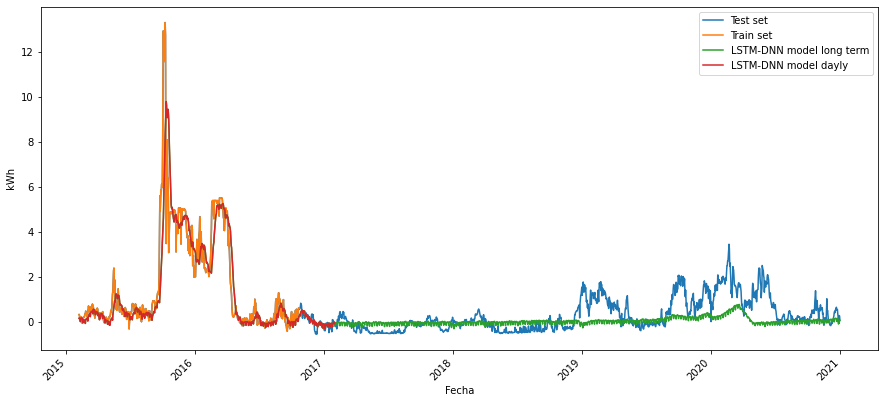

<AxesSubplot:xlabel='Fecha', ylabel=' kWh '>

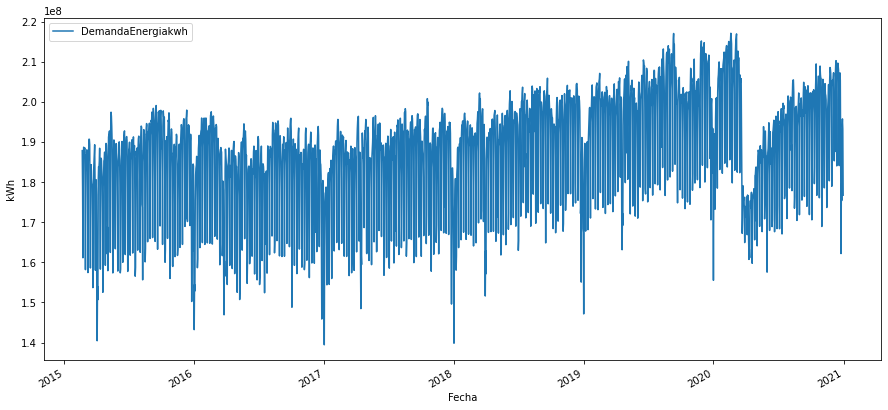

In [23]:
daux=pd.DataFrame()
#daux['Fecha']=df['Fecha']
init_date=5500
daux['Test set']=pd.Series(normalize_precio(Y[init_date:]))
daux['Train set']= pd.Series(normalize_precio(Y_train[init_date:]))
#daux['train_precio_norm']=Y_train[6000:]
daux['LSTM-DNN model long term']=pd.Series(dnn_predictions[init_date:].reshape(len(dnn_predictions[init_date:]),))
daux['LSTM-DNN model dayly']=pd.Series(old_pred[init_date:].reshape(len(old_pred[init_date:]),))
#daux['Fecha']=df['Fecha'].iloc[-len(Y_test):]
daux.set_index(df['Fecha'].iloc[init_date+n_steps+1:], inplace=True)
daux
fig1, ax1 = plt.subplots(figsize=(15,7))
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g')#,daux['old pred model'],'p')
#plt.plot(daux['precio_norm'],'b',daux['train_precio_norm'], 'r',daux['LSTM-DNN model'],'g',daux['old pred model'],'m')
daux.plot(y=['Test set','Train set','LSTM-DNN model long term','LSTM-DNN model dayly'],ylabel=r' kWh ',ax=ax1)
#plt.title('Test set')
plt.xticks(rotation=45)
plt.show()

total='DemandaEnergiakwh'
fig1, ax1 = plt.subplots(figsize=(15,7))
# use unstack()
dfinalday.iloc[init_date+n_steps+n_steps+1:].plot(x='Fecha',y=total,ylabel=r' kWh ',ax=ax1)

In [24]:
No

1431